# Create, evaluate, and score a fraud detection model

## Introduction

In this notebook, you walk through the Synapse Data Science in Microsoft Fabric workflow with an end-to-end example. The scenario is to build a fraud detection model, using ML algorithms trained on historical data and then use the model to detect future fraudulent transactions.

The main steps in this notebook are:

1. Install custom libraries
2. Load the data 
3. Understand and process the data through exploratory data analysis
4. Train a machine learning model using scikit-learn and track experiments using MLflow and Fabric Autologging feature
5. Save and register the best performing machine learning model
6. Load the machine learning model for scoring and making predictions

#### Prerequisites
- [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to this notebook. You'll be downloading data from a public blob and storing the data in the lakehouse. 

## Step 1: Install custom libraries
When developing a machine learning model or doing ad-hoc data analysis, you may need to quickly install a custom library (such as `imblearn`) for your Apache Spark session. To install libraries, you have two choices. 

1. You can use the inline installation capabilities (such as `%pip` and `%conda`) to quickly get started with new libraries. Note that this installation option would install the custom libraries only in the current notebook and not in the workspace.

```python
# Use pip to install libraries
%pip install <library name>

# Use conda to install libraries
%conda install <library name>
```

2. Alternatively, you can create a Fabric environment, install libraries from public sources or upload custom libraries to it, and then your workspace admin can attach the environment as the default for the workspace. All the libraries in the environment will then become available for use in any notebooks and Spark job definitions in the workspace. For more information on environments, see [create, configure, and use an environment in Microsoft Fabric](https://aka.ms/fabric/create-environment).

For this notebook, you install the `imblearn` library, using `%pip install`. When you run `%pip install`, the PySpark kernel restarts; therefore, you should install the library before you run any other cells in the notebook.

In [ ]:
# Use pip to install imblearn
%pip install imblearn

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 8, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 3.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: /nfs4/pyenv-31fa20a3-dc98-43d3-a862-5a57aca7c134/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Load the data

### Dataset

The fraud detection dataset contains credit card transactions made by European cardholders in September 2013 over the course of two days. The dataset contains only numerical features, which is the result of a Principal Component Analysis (PCA) transformation that was done on the original features. The only features that haven't been transformed with PCA are `Time` and `Amount`. To protect confidentiality, the original features or more background information about the dataset can't be provided.

- The features `V1`, `V2`, `V3`, …, `V28` are the principal components obtained with PCA.
- The feature `Time` contains the elapsed seconds between each transaction and the first transaction in the dataset.
- The feature `Amount` is the transaction amount. This feature can be used for example-dependent cost-sensitive learning.
- The column `Class` is the response (target) variable and takes the value `1` for fraud and `0` otherwise.

Out of the 284,807 transactions, only 492 are fraudulent. Therefore, the minority class (fraud) accounts for only about 0.172% of the data, making the dataset highly imbalanced.

The following table shows a preview of the _creditcard.csv_ data:

|"Time"|"V1"|"V2"|"V3"|"V4"|"V5"|"V6"|"V7"|"V8"|"V9"|"V10"|"V11"|"V12"|"V13"|"V14"|"V15"|"V16"|"V17"|"V18"|"V19"|"V20"|"V21"|"V22"|"V23"|"V24"|"V25"|"V26"|"V27"|"V28"|"Amount"|"Class"|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|0|-1.3598071336738|-0.0727811733098497|2.53634673796914|1.37815522427443|-0.338320769942518|0.462387777762292|0.239598554061257|0.0986979012610507|0.363786969611213|0.0907941719789316|-0.551599533260813|-0.617800855762348|-0.991389847235408|-0.311169353699879|1.46817697209427|-0.470400525259478|0.207971241929242|0.0257905801985591|0.403992960255733|0.251412098239705|-0.018306777944153|0.277837575558899|-0.110473910188767|0.0669280749146731|0.128539358273528|-0.189114843888824|0.133558376740387|-0.0210530534538215|149.62|"0"|
|0|1.19185711131486|0.26615071205963|0.16648011335321|0.448154078460911|0.0600176492822243|-0.0823608088155687|-0.0788029833323113|0.0851016549148104|-0.255425128109186|-0.166974414004614|1.61272666105479|1.06523531137287|0.48909501589608|-0.143772296441519|0.635558093258208|0.463917041022171|-0.114804663102346|-0.183361270123994|-0.145783041325259|-0.0690831352230203|-0.225775248033138|-0.638671952771851|0.101288021253234|-0.339846475529127|0.167170404418143|0.125894532368176|-0.00898309914322813|0.0147241691924927|2.69|"0"|


### Introduction to SMOTE

`imblearn` (imbalanced learn) is a library that uses the Synthetic Minority Oversampling Technique (SMOTE) approach to address the problem of imbalanced classification. Imbalanced classification happens when there are too few examples of the minority class for a model to effectively learn the decision boundary. SMOTE is the most widely used approach to synthesize new samples for the minority class. You can read more about SMOTE [here](https://cran.r-project.org/web/packages/imbalance/imbalance.pdf) and [here](https://cran.r-project.org/web/packages/imbalance/vignettes/imbalance.pdf).


You can apply the SMOTE approach by using the `imblearn` library that you installed in Step 1.

> [!TIP]
> By defining the following parameters, you can apply this notebook on different datasets easily.

In [ ]:
IS_CUSTOM_DATA = False  # if True, dataset has to be uploaded manually

TARGET_COL = "Class"  # target column name
IS_SAMPLE = False  # if True, use only <SAMPLE_ROWS> rows of data for training, otherwise use all data
SAMPLE_ROWS = 5000  # if IS_SAMPLE is True, use only this number of rows for training

DATA_FOLDER = "Files/fraud-detection/"  # folder with data files
DATA_FILE = "creditcard.csv"  # data file name

EXPERIMENT_NAME = "aisample-fraud"  # MLflow experiment name

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 10, Finished, Available)

### Download the dataset and upload to the lakehouse

The following code downloads a publicly available version of the dataset and then stores it in a Fabric lakehouse.

> [!IMPORTANT]
> **Make sure you [add a lakehouse](https://aka.ms/fabric/addlakehouse) to the notebook before running it. Failure to do so will result in an error.**

In [ ]:
if not IS_CUSTOM_DATA:
    # Download data files into lakehouse if not already there
    import os, requests

    remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/Credit_Card_Fraud_Detection"
    fname = "creditcard.csv"
    download_path = f"/lakehouse/default/{DATA_FOLDER}/raw"

    if not os.path.exists("/lakehouse/default"):
        raise FileNotFoundError("Default lakehouse not found, please add a lakehouse and restart the session.")
    os.makedirs(download_path, exist_ok=True)
    if not os.path.exists(f"{download_path}/{fname}"):
        r = requests.get(f"{remote_url}/{fname}", timeout=30)
        with open(f"{download_path}/{fname}", "wb") as f:
            f.write(r.content)
    print("Downloaded demo data files into lakehouse.")


StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 11, Finished, Available)

Downloaded demo data files into lakehouse.


Start recording the time it takes to run this notebook.

In [ ]:
# Record the notebook running time
import time

ts = time.time()

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 12, Finished, Available)

### Set up MLflow experiment tracking

Experiment tracking is the process of saving all relevant experiment-related information for every experiment you run. Sometimes, it's easy to observe that there is no way to get better results when running a particular experiment. In such a situation, you're better off simply stopping the experiment and trying a new one. 

The Data Science experience in Microsoft Fabric includes autologging, which significantly reduces the amount of code required to automatically log the parameters, metrics, and items of a machine learning model during training. This feature extends MLflow autologging capabilities and is deeply integrated into the Data Science experience. Using autologging, you can easily track and compare the performance of different models and experiments without the need for manual tracking. For more information, see [Autologging in Microsoft Fabric](https://aka.ms/fabric-autologging).

In [ ]:
# Set up MLflow for experiment tracking
import mlflow

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Disable MLflow autologging

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 13, Finished, Available)

2023/09/07 17:34:29 INFO mlflow.tracking.fluent: Experiment with name 'aisample-fraud' does not exist. Creating a new experiment.


> [!TIP]
> You can disable Microsoft Fabric autologging in a notebook session by calling `mlflow.autolog()` and setting `disable=True` as shown in the previous code cell.

### Read raw data from the lakehouse

This code reads raw data from the lakehouse.

In [ ]:
df = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", True)
    .load(f"{DATA_FOLDER}/raw/{DATA_FILE}")
    .cache()
)

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 14, Finished, Available)

## Step 3: Perform exploratory data analysis

In this section, you'll begin by exploring the raw data and high-level statistics. You'll then transform the data by casting the columns into the correct types and converting from a Spark DataFrame into a pandas DataFrame for easier visualization. Finally, you explore and visualize the class distributions in the data.

### Display the raw data

1. Explore the raw data and view high-level statistics by using the `display` command. For more information, see [Notebook visualization in Microsoft Fabric](https://aka.ms/fabric/visualization).

In [ ]:
display(df)

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 15, Finished, Available)

SynapseWidget(Synapse.DataFrame, eae3f282-638e-47a8-9a34-04f298f02edd)

2. Print some basic information about the dataset.

In [ ]:
# Print dataset basic information
print("records read: " + str(df.count()))
print("Schema: ")
df.printSchema()

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 16, Finished, Available)

records read: 284807
Schema: 
root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable =

### Transform the data

1. Cast the dataset's columns into the correct types.

In [ ]:
import pyspark.sql.functions as F

df_columns = df.columns
df_columns.remove(TARGET_COL)

# Ensure the TARGET_COL is the last column
df = df.select(df_columns + [TARGET_COL]).withColumn(TARGET_COL, F.col(TARGET_COL).cast("int"))

if IS_SAMPLE:
    df = df.limit(SAMPLE_ROWS)

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 17, Finished, Available)

2. Convert Spark DataFrame to Pandas DataFrame for easier visualization and processing.

In [ ]:
df_pd = df.toPandas()

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 18, Finished, Available)

### Explore the  class distribution in the dataset

1. Display the class distribution in the dataset.

In [ ]:
# The distribution of classes in the dataset
print('No Frauds', round(df_pd['Class'].value_counts()[0]/len(df_pd) * 100,2), '% of the dataset')
print('Frauds', round(df_pd['Class'].value_counts()[1]/len(df_pd) * 100,2), '% of the dataset')

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 19, Finished, Available)

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


The class distribution shows that most of the transactions are nonfraudulent. Therefore, data preprocessing is required before model training in order to avoid overfitting.

2. Use a plot to show the class imbalance in the dataset, by viewing the distribution of fraudulent versus nonfraudulent transactions.

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 20, Finished, Available)

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

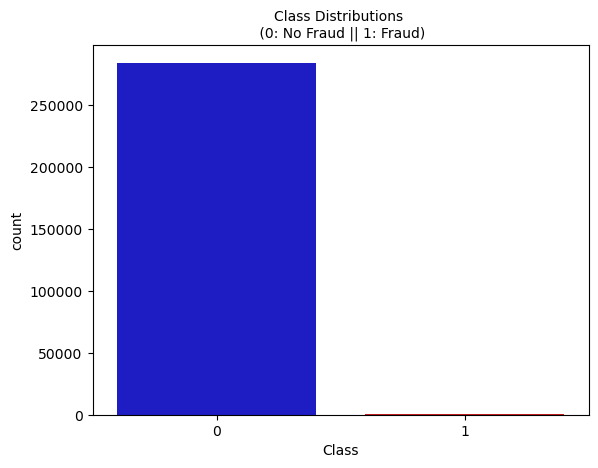

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ["#0101DF", "#DF0101"]
sns.countplot(x='Class', data=df_pd, palette=colors) 
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=10)

The distribution plot clearly shows the class imbalance in the dataset.

3. Show the five-number summary (the minimum score, first quartile, median, third quartile, the maximum score) for the transaction amount, using Box plots.

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 21, Finished, Available)

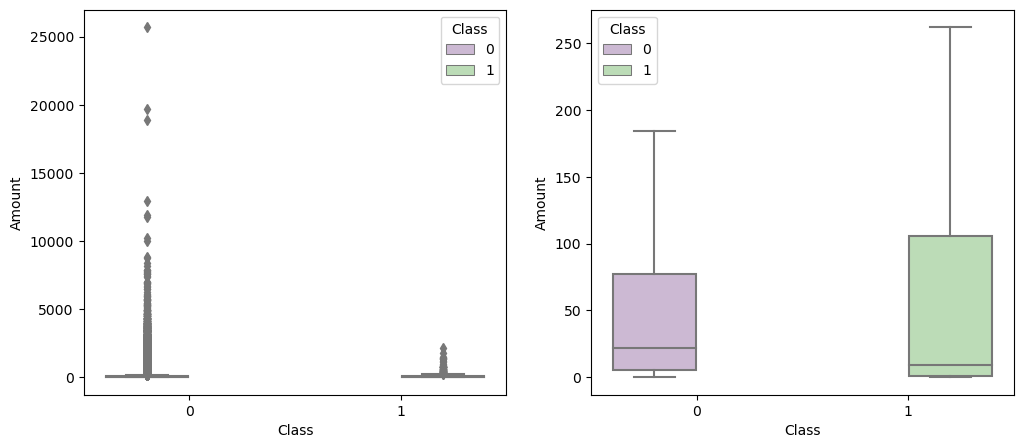

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df_pd, palette="PRGn", showfliers=True) # Remove outliers from the plot
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df_pd, palette="PRGn", showfliers=False) # Kepp outliers from the plot
plt.show()

When the data is highly imbalanced, these Box plots may not demonstrate accurate insights. Alternatively, you can address the class imbalance problem first and then create the same plots for more accurate insights.

## Step 4: Train and evaluate the model

In this section, you train a LightGBM model to classify the fraud transactions. You train a LightGBM model on the imbalanced dataset and also on the balanced dataset (via SMOTE) and compare the performance of both models.

### Prepare training and test datasets

Before training, split the data into the training and test datasets.

In [ ]:
# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_pd, test_size=0.15)
feature_cols = [c for c in df_pd.columns.tolist() if c not in [TARGET_COL]]


StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 22, Finished, Available)

### Apply SMOTE to the training data to synthesize new samples for the minority class

Apply SMOTE only to the training dataset, and not to the test dataset. When you score the model with the test data, you want an approximation of the model's performance on unseen data in production. For this approximation to be valid, your test data needs to represent production data as closely as possible by having the original imbalanced distribution.

In [ ]:
# Apply SMOTE to the training data
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE

X = train[feature_cols]
y = train[TARGET_COL]
print("Original dataset shape %s" % Counter(y))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print("Resampled dataset shape %s" % Counter(y_res))

new_train = pd.concat([X_res, y_res], axis=1)

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 23, Finished, Available)

Original dataset shape Counter({0: 241663, 1: 422})
Resampled dataset shape Counter({0: 241663, 1: 241663})


### Train machine learning models and run experiments

Apache Spark in Microsoft Fabric enables machine learning with big data, making it possible to obtain valuable insights from large amounts of structured, unstructured, and fast-moving data. There are several options when training machine learning models using Apache Spark in Microsoft Fabric: Apache Spark MLlib, SynapseML, and various other open-source libraries. For more information, see [Train machine learning models in Microsoft Fabric](https://aka.ms/fabric/MLTrain). 

A **machine learning experiment** is the primary unit of organization and control for all related machine learning runs. A **run** corresponds to a single execution of model code. Machine learning **experiment tracking** refers to the process of managing all the different experiments and their components, such as parameters, metrics, models, and other artifacts. Experiment tracking allows you to organize all the required components of a specific machine learning experiment and to easily reproduce past results, using saved experiments. For more information on machine learning experiments, see [Machine learning experiments in Microsoft Fabric](https://aka.ms/synapse-experiment).

1. Update the MLflow autologging configuration to track additional metrics, parameters, and files, by setting `exclusive=False`.

In [ ]:
mlflow.autolog(exclusive=False)

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 24, Finished, Available)

2023/09/07 17:34:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/09/07 17:35:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/09/07 17:35:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


2. Train two models using **LightGBM**: one model on the imbalanced dataset and the other on the balanced (via SMOTE) dataset. Then compare the performance of the two models.

In [ ]:
import lightgbm as lgb

model = lgb.LGBMClassifier(objective="binary") # imbalanced dataset
smote_model = lgb.LGBMClassifier(objective="binary") # balanced dataset

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 25, Finished, Available)

2023/09/07 17:35:02 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


In [ ]:
# Train LightGBM for both imbalanced and balanced datasets and define the evaluation metrics
print("Start training with imbalanced data:\n")
with mlflow.start_run(run_name="raw_data") as raw_run:
    model = model.fit(
        train[feature_cols],
        train[TARGET_COL],
        eval_set=[(test[feature_cols], test[TARGET_COL])],
        eval_metric="auc",
        callbacks=[
            lgb.log_evaluation(10),
        ],
    )

print(f"\n\nStart training with balanced data:\n")
with mlflow.start_run(run_name="smote_data") as smote_run:
    smote_model = smote_model.fit(
        new_train[feature_cols],
        new_train[TARGET_COL],
        eval_set=[(test[feature_cols], test[TARGET_COL])],
        eval_metric="auc",
        callbacks=[
            lgb.log_evaluation(10),
        ],
    )

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 26, Finished, Available)

Start training with imbalanced data:

[10]	valid_0's auc: 0.846214	valid_0's binary_logloss: 0.0198988
[20]	valid_0's auc: 0.809169	valid_0's binary_logloss: 0.0366592
[30]	valid_0's auc: 0.832858	valid_0's binary_logloss: 0.0550901
[40]	valid_0's auc: 0.852954	valid_0's binary_logloss: 0.0655302
[50]	valid_0's auc: 0.835051	valid_0's binary_logloss: 0.121884
[60]	valid_0's auc: 0.832776	valid_0's binary_logloss: 0.0795111
[70]	valid_0's auc: 0.831284	valid_0's binary_logloss: 0.335081
[80]	valid_0's auc: 0.915596	valid_0's binary_logloss: 0.0567016
[90]	valid_0's auc: 0.937667	valid_0's binary_logloss: 0.0717687
[100]	valid_0's auc: 0.947153	valid_0's binary_logloss: 0.0429635


Start training with balanced data:

[10]	valid_0's auc: 0.979671	valid_0's binary_logloss: 0.225364
[20]	valid_0's auc: 0.984363	valid_0's binary_logloss: 0.0967023
[30]	valid_0's auc: 0.984835	valid_0's binary_logloss: 0.0495527
[40]	valid_0's auc: 0.984481	valid_0's binary_logloss: 0.028981
[50]	valid_0's au

2023/09/07 17:35:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


### Determine feature importance for training

Determine feature importance for the model that you trained on the imbalanced dataset.

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 27, Finished, Available)

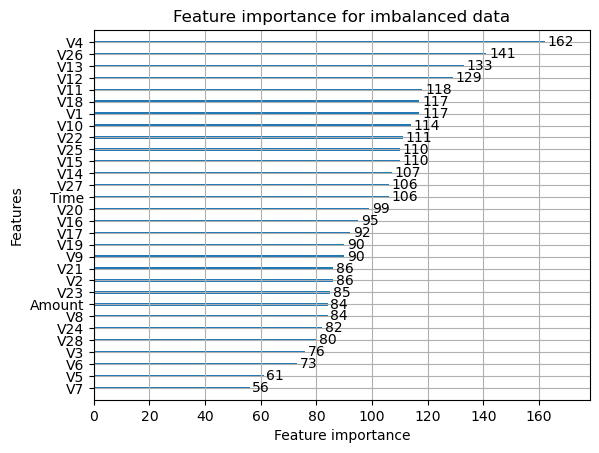

In [ ]:
with mlflow.start_run(run_id=raw_run.info.run_id):
    importance = lgb.plot_importance(
        model, title="Feature importance for imbalanced data"
    )
    importance.figure.savefig("feauture_importance.png")
    mlflow.log_figure(importance.figure, "feature_importance.png")

Determine feature importance for the model that you trained on balanced (via SMOTE) dataset.

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 28, Finished, Available)

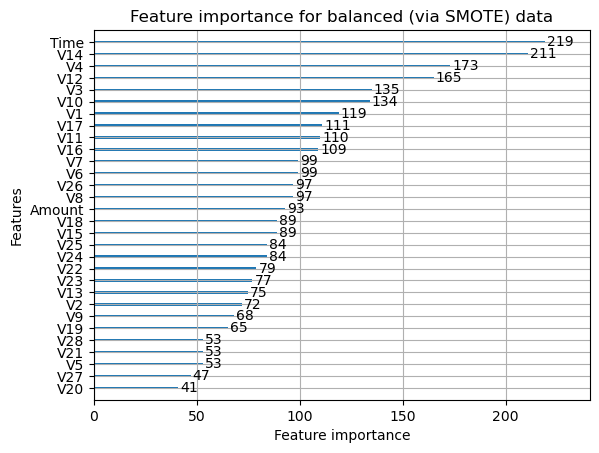

In [ ]:
with mlflow.start_run(run_id=smote_run.info.run_id):
    smote_importance = lgb.plot_importance(
        smote_model, title="Feature importance for balanced (via SMOTE) data"
    )
    smote_importance.figure.savefig("feauture_importance_smote.png")
    mlflow.log_figure(smote_importance.figure, "feauture_importance_smote.png")

A comparison of the feature importance plots shows that the important features are drastically different when you train a model with the imbalanced dataset versus the balanced dataset.

### Evaluate the models

In this section, you evaluate the two trained models:

- `model` trained on raw, __imbalanced data__
- `smote_model` trained on __balanced data__

#### Compute model metrics

1. First define a function `prediction_to_spark` that performs predictions and converts the prediction results into a Spark DataFrame. You can later compute model statistics on the prediction results using [SynapseML](https://aka.ms/fabric/SynapseEval).

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DoubleType

def prediction_to_spark(model, test):
    predictions = model.predict(test[feature_cols], num_iteration=model.best_iteration_)
    predictions = tuple(zip(test[TARGET_COL].tolist(), predictions.tolist()))
    dataColumns = [TARGET_COL, "prediction"]
    predictions = (
        spark.createDataFrame(data=predictions, schema=dataColumns)
        .withColumn(TARGET_COL, col(TARGET_COL).cast(IntegerType()))
        .withColumn("prediction", col("prediction").cast(DoubleType()))
    )

    return predictions

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 29, Finished, Available)

2. Use the `prediction_to_spark` function to perform predictions with the two models `model` and `smote_model`.


In [ ]:
predictions = prediction_to_spark(model, test)
smote_predictions = prediction_to_spark(smote_model, test)
predictions.limit(10).toPandas()

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 30, Finished, Available)

,Class,prediction
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0


3. Compute metrics for the two models.

In [ ]:
from synapse.ml.train import ComputeModelStatistics

metrics = ComputeModelStatistics(
    evaluationMetric="classification", labelCol=TARGET_COL, scoredLabelsCol="prediction"
).transform(predictions)

smote_metrics = ComputeModelStatistics(
    evaluationMetric="classification", labelCol=TARGET_COL, scoredLabelsCol="prediction"
).transform(smote_predictions)
display(metrics)

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 31, Finished, Available)

SynapseWidget(Synapse.DataFrame, f28e4855-8f78-457c-a52b-cf62ff3f9674)

#### Evaluate model performance with a confusion matrix

A **confusion matrix** displays the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) that a model produces when scored with test data. For binary classification, you get a `2x2` confusion matrix. For multi-class classification, you get an `nxn` confusion matrix, where `n` is the the number of classes. 

1. Use a confusion matrix to summarize the performances of the trained machine learning models on the test data. 

In [ ]:
# Collect confusion matrix value
cm = metrics.select("confusion_matrix").collect()[0][0].toArray()
smote_cm = smote_metrics.select("confusion_matrix").collect()[0][0].toArray()
print(cm)

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 32, Finished, Available)

[[4.2622e+04 3.0000e+01]
 [2.6000e+01 4.4000e+01]]


2. Plot the confusion matrix for the predictions of `smote_model` (trained on __balanced data__).

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 33, Finished, Available)

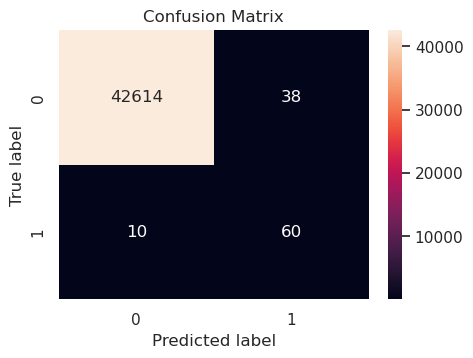

In [ ]:
# Plot Confusion Matrix
import seaborn as sns

def plot(cm):
    """
    Plot the confusion matrix.
    """
    sns.set(rc={"figure.figsize": (5, 3.5)})
    ax = sns.heatmap(cm, annot=True, fmt=".20g")
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    return ax

with mlflow.start_run(run_id=smote_run.info.run_id):
    ax = plot(smote_cm)
    mlflow.log_figure(ax.figure, "ConfusionMatrix.png")

3. Plot the confusion matrix for the predictions of `model` (trained on raw, __imbalanced data__).

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 34, Finished, Available)

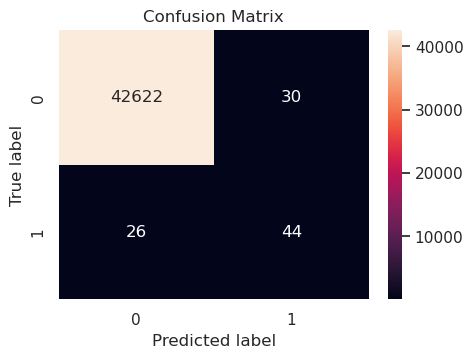

In [ ]:
with mlflow.start_run(run_id=raw_run.info.run_id):
    ax = plot(cm)
    mlflow.log_figure(ax.figure, "ConfusionMatrix.png")

#### Evaluate model performance with AUC-ROC and AUPRC measures

The **Area Under the Curve Receiver Operating Characteristic (AUC-ROC)** measure is widely used to assess the performance of binary classifiers. AUC-ROC is a chart that visualizes the trade-off between the true positive rate (TPR) and the false positive rate (FPR).

In some cases, it's more appropriate to evaluate your classifier based on the **Area Under the Precision-Recall Curve (AUPRC)** measure. The AUPRC is a curve that combines two rates: 
- the precision, also called the positive predictive value (PPV), and 
- the recall, also called the true positive rate (TPR).

1. Define a function that returns the AUC-ROC and AUPRC measures.

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def evaluate(predictions):
    """
    Evaluate the model by computing AUROC and AUPRC with the predictions.
    """

    # Initialize the binary evaluator
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol=TARGET_COL)

    _evaluator = lambda metric: evaluator.setMetricName(metric).evaluate(predictions)

    # Calculate AUROC, baseline 0.5
    auroc = _evaluator("areaUnderROC")
    print(f"The AUROC is: {auroc:.4f}")

    # Calculate AUPRC, baseline positive rate (0.172% in the data)
    auprc = _evaluator("areaUnderPR")
    print(f"The AUPRC is: {auprc:.4f}")

    return auroc, auprc


StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 35, Finished, Available)

2. Log the AUC-ROC and AUPRC metrics for the model trained on __imbalanced data__.

In [ ]:
with mlflow.start_run(run_id=raw_run.info.run_id):
    auroc, auprc = evaluate(predictions)
    mlflow.log_metrics({"AUPRC": auprc, "AUROC": auroc})
    mlflow.log_params({"Data_Enhancement": "None", "DATA_FILE": DATA_FILE})

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 36, Finished, Available)

The AUROC is: 0.8139
The AUPRC is: 0.4845


3. Log the AUC-ROC and AUPRC metrics for the model trained on __balanced data__.

In [ ]:
with mlflow.start_run(run_id=smote_run.info.run_id):
    auroc, auprc = evaluate(smote_predictions)
    mlflow.log_metrics({"AUPRC": auprc, "AUROC": auroc})
    mlflow.log_params({"Data_Enhancement": "SMOTE", "DATA_FILE": DATA_FILE})

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 37, Finished, Available)

The AUROC is: 0.9281
The AUPRC is: 0.5686


The model trained on balanced data returns higher AUC-ROC and AUPRC values compared to the model trained on imbalanced data. Based on these measures, SMOTE appears to be an effective technique for enhancing model performance when working with highly imbalanced data.

As shown in the following image, any experiment is logged along with its respective name, and you can track the experiment's parameters and performance metrics in your workspace.

<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/Credit_Card_Fraud_Detection/fraud-mlflow.png"  width="45%" height="10%">

The following image also shows performance metrics for the model trained on the balanced dataset (in **Version 2**). You can select **Version 1** to see the metrics for the model trained on the imbalanced dataset. Comparing the metrics, you'll notice that the AUROC is higher for the model trained with the balanced dataset, indicating that this model is better at correctly predicting `0` classes as `0` and `1` classes as `1`.

<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/Credit_Card_Fraud_Detection/fraud-logging.png"  width="45%" height="10%"> 


## Step 5: Register the models

Use MLflow to register the two models.

In [ ]:
# Register the model
registered_model_name = f"{EXPERIMENT_NAME}-lightgbm"

raw_model_uri = "runs:/{}/model".format(raw_run.info.run_id)
mlflow.register_model(raw_model_uri, registered_model_name)

smote_model_uri = "runs:/{}/model".format(smote_run.info.run_id)
mlflow.register_model(smote_model_uri, registered_model_name)

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 38, Finished, Available)

Successfully registered model 'aisample-fraud-lightgbm'.
2023/09/07 17:35:55 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: aisample-fraud-lightgbm, version 1
Created version '1' of model 'aisample-fraud-lightgbm'.
Successfully registered model 'aisample-fraud-lightgbm'.
2023/09/07 17:35:57 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: aisample-fraud-lightgbm, version 2
Created version '2' of model 'aisample-fraud-lightgbm'.


<ModelVersion: creation_timestamp=1694108156878, current_stage='None', description='', last_updated_timestamp=1694108156878, name='aisample-fraud-lightgbm', run_id='97a3428b-b326-4d87-8975-9b9fbd5964ef', run_link='', source='abfss://0a29b6ce-2000-4434-9b3c-e7a48030a82b@olswestccdavcqqagmcte3vt.dfs.core.windows.net/172a6fba-71fb-4277-afda-4118ee37a05c/7b33b8e3-f4e6-44aa-aab2-46a44b120a64/artifacts', status='READY', status_message='', tags={}, user_id='', version='2'>

## Step 6: Save the prediction results

Microsoft Fabric allows users to operationalize machine learning models with a scalable function called `PREDICT`, which supports batch scoring (or batch inferencing) in any compute engine.

You can generate batch predictions directly from the Microsoft Fabric notebook or from a given model's item page. For more information on how to use `PREDICT`, see [Model scoring with PREDICT in Microsoft Fabric](https://aka.ms/fabric-predict).


1. Load the better-performing model (*Version 2*) for batch scoring and generate the prediction results.

In [ ]:
from synapse.ml.predict import MLFlowTransformer

spark.conf.set("spark.synapse.ml.predict.enabled", "true")

model = MLFlowTransformer(
    inputCols=feature_cols,
    outputCol="prediction",
    modelName=f"{EXPERIMENT_NAME}-lightgbm",
    modelVersion=2,
)

test_spark = spark.createDataFrame(data=test, schema=test.columns.to_list())

batch_predictions = model.transform(test_spark)

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 39, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


2. Save predictions into the lakehouse.

In [ ]:
# Save the predictions into the lakehouse
batch_predictions.write.format("delta").mode("overwrite").save(f"{DATA_FOLDER}/predictions/batch_predictions")

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 40, Finished, Available)

In [ ]:
# Determine the entire runtime
batch_predictions.limit(5).toPandas()
print(f"Full run cost {int(time.time() - ts)} seconds.")

StatementMeta(, 32e3c016-db9c-4f83-b8c0-f7af0f59032f, 41, Finished, Available)

Full run cost 102 seconds.
